FROM HERE, XGB TUTORIAL FOR HISTOGRAMS USED  https://github.com/k-woodruff/bdt-tutorial/blob/master/bdt_tutorial.ipynb

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

Loading Data

In [5]:
data = pd.read_csv('bank-additional-full.csv', delimiter=';')
data.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
label_encoder = LabelEncoder()
data['y'] = label_encoder.fit_transform(data['y'])

Visualizing Data

In [8]:
print('Size of data: {}'.format(data.shape))
print('Number of events/rows: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))

print ('\nList of features in dataset:')
for col in data.columns:
    print(col)

Size of data: (41188, 21)
Number of events/rows: 41188
Number of columns: 21

List of features in dataset:
age
job
marital
education
default
housing
loan
contact
month
day_of_week
duration
campaign
pdays
previous
poutcome
emp.var.rate
cons.price.idx
cons.conf.idx
euribor3m
nr.employed
y


In [10]:
# look at column labels --- notice last one is "Label" and first is "EventId" also "Weight"
print('Number of "yes events": {}'.format(len(data[data.y == 1])))
print('Number of "no events": {}'.format(len(data[data.y == 0])))

print('Fraction signal: {}'.format(len(data[data.y == 1])/(float)(len(data[data.y == 1]) + len(data[data.y== 0]))))

Number of "yes events": 4640
Number of "no events": 36548
Fraction signal: 0.11265417111780131


From Turorial:
First, we'll sliceup the data into training and testing sets. 

Here, we take 20% for the test set, which is arbitrary.

In this file, all samples are independent and ordered randomly, so we can just grab a chunk.

We can also change the data type of the "Label" column to the pandas type "category" for easier use later.

In [24]:
data['y'] = data.y.astype('category')

In [26]:
#data_train = data[:32950]   #Does this make 20% for our dataset? Maybe not...
#data_test = data[32950:]

Check to make sure we did it right:

In [29]:
print('Number of training samples: {}'.format(len(data_train)))
print('Number of testing samples: {}'.format(len(data_test)))

print('\nNumber of yes events in training set: {}'.format(len(data_train[data_train.y == 1])))
print('Number of no events in training set: {}'.format(len(data_train[data_train.y == 0])))
print('Fraction signal: {}'.format(len(data_train[data_train.y == 1])/(float)(len(data_train[data_train.Label == 1]) + len(data_train[data_train.y == 0]))))

Number of training samples: 32950
Number of testing samples: 8238

Number of yes events in training set: 2100
Number of no events in training set: 30850


AttributeError: 'DataFrame' object has no attribute 'Label'

The DMatrix object takes as arguments:
- data --- the features
- label --- 1/0 or true/false for binary data (we have to convert our label to bool from string s/b)
- missing --- how missing values are represented (here as -999.0)
- feature_names --- the names of all of the features (optional)

In [32]:
X = data.drop(columns='y')   #the result column, separation of features from target as X and Y
y = data['y']

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                       'contact', 'month', 'day_of_week', 'poutcome']
for col in categorical_columns:
    X[col] = X[col].astype('category')   #needed to change to categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)
print(X_train)

       age          job   marital            education  default housing loan  \
33177   27  blue-collar   married             basic.9y       no     yes   no   
7784    38      unknown  divorced          high.school  unknown     yes   no   
33983   32   technician   married    university.degree       no     yes   no   
19122   41   technician   married    university.degree       no     yes   no   
17090   50      retired   married  professional.course       no     yes   no   
...    ...          ...       ...                  ...      ...     ...  ...   
5520    36     services    single             basic.9y       no     yes  yes   
35814   31   technician   married    university.degree       no     yes   no   
20463   33   technician   married  professional.course       no      no   no   
18638   36       admin.    single    university.degree       no     yes   no   
35683   36  blue-collar   married             basic.9y       no     yes   no   

         contact month day_of_week  dur

In [39]:
#just to make sure categorical columns retain 'category' dtype after the split
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

In [41]:
#Dataset is highly imbalanced (e.g., many more background events than signal), the model may favor predicting background over signal.
#Adding a weight parameter for the signal class actually fixes the trouble with the absence of a peak at 1

#DMatrix
dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(data=X_test, label=y_test, enable_categorical=True)
#print(dtest)
# Define parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    'seed': 42
}


In [43]:
# Train the model
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10)

# Predict and evaluate
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

[0]	train-logloss:0.63037	eval-logloss:0.63158
[1]	train-logloss:0.60580	eval-logloss:0.60821
[2]	train-logloss:0.55888	eval-logloss:0.56229
[3]	train-logloss:0.51949	eval-logloss:0.52393
[4]	train-logloss:0.50499	eval-logloss:0.51034
[5]	train-logloss:0.47435	eval-logloss:0.48044
[6]	train-logloss:0.44792	eval-logloss:0.45491
[7]	train-logloss:0.42554	eval-logloss:0.43323
[8]	train-logloss:0.40603	eval-logloss:0.41407
[9]	train-logloss:0.38962	eval-logloss:0.39840
[10]	train-logloss:0.37507	eval-logloss:0.38456
[11]	train-logloss:0.36264	eval-logloss:0.37254
[12]	train-logloss:0.35724	eval-logloss:0.36780
[13]	train-logloss:0.34664	eval-logloss:0.35782
[14]	train-logloss:0.33748	eval-logloss:0.34904
[15]	train-logloss:0.32999	eval-logloss:0.34199
[16]	train-logloss:0.32658	eval-logloss:0.33919
[17]	train-logloss:0.31949	eval-logloss:0.33282
[18]	train-logloss:0.31655	eval-logloss:0.33042
[19]	train-logloss:0.31109	eval-logloss:0.32549
[20]	train-logloss:0.30635	eval-logloss:0.32111
[2

In [45]:
predictions = model.predict(dtest)

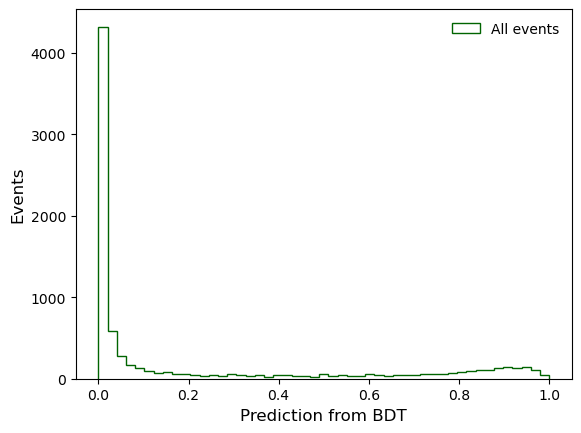

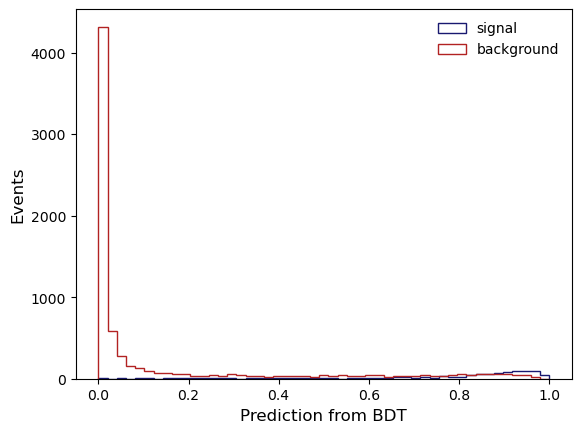

In [47]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);
plt.show()
# plot signal and background separately

plt.figure();
plt.hist(predictions[dtest.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(predictions[~(dtest.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);
plt.show()


In [115]:
print("Predictions summary:")
print("Min:", np.min(predictions))
print("Max:", np.max(predictions))
print("Mean:", np.mean(predictions))
print("Std Dev:", np.std(predictions))

Predictions summary:
Min: 0.00012145581
Max: 0.99230933
Mean: 0.21639176
Std Dev: 0.33109057


In [117]:
print("Label encoding verification:")
print(y_test.value_counts())


Label encoding verification:
y
0    7303
1     935
Name: count, dtype: int64


In [119]:
#Purity vs Efficiency Plots
import numpy as np

C:\Users\49682172\AppData\Local\Temp\ipykernel_72788\4138080393.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.plot(nsignal/len(data_test[data_test.y == '1']),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
C:\Users\49682172\AppData\Local\Temp\ipykernel_72788\4138080393.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(nsignal/len(data_test[data_test.y == '1']),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
C:\Users\49682172\AppData\Local\Temp\ipykernel_72788\4138080393.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False);


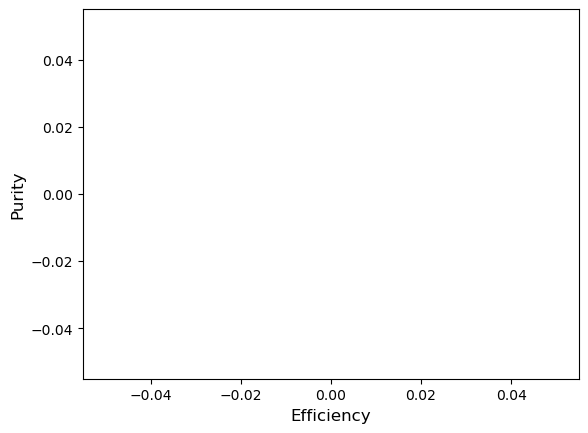

In [121]:
# choose score cuts:
cuts = np.linspace(0,1,500);
nsignal = np.zeros(len(cuts));
nbackground = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    nsignal[i] = len(np.where(predictions[dtest.get_label().astype(bool)] > cut)[0]);
    nbackground[i] = len(np.where(predictions[~(dtest.get_label().astype(bool))] > cut)[0]);
    
# plot efficiency vs. purity (ROC curve)
plt.figure();
plt.plot(nsignal/len(data_test[data_test.y == '1']),nsignal/(nsignal + nbackground),'o-',color='blueviolet');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);
plt.show()

In [123]:
xgb.plot_importance(model,grid=False);

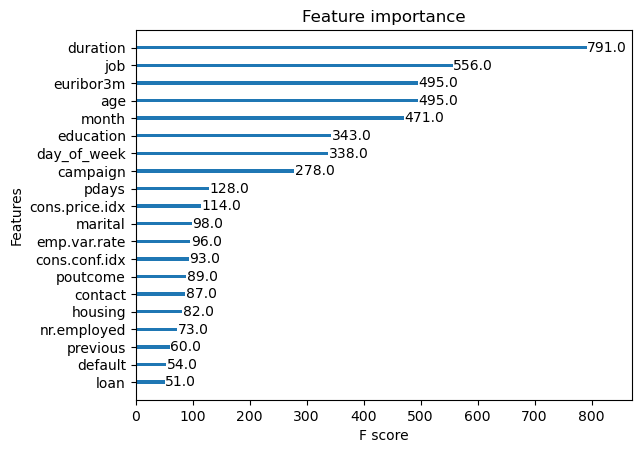

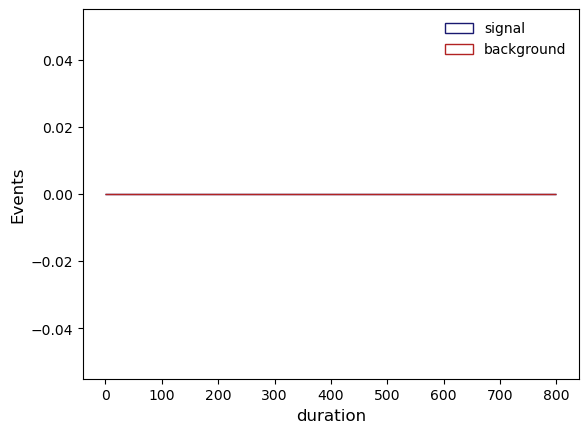

In [125]:
plt.figure();
plt.hist(data_train.duration[data_train.y == '1'],bins=np.linspace(0,800,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(data_train.duration[data_train.y == '0'],bins=np.linspace(0,800,50),
         histtype='step',color='firebrick',label='background');

plt.xlabel('duration',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);
plt.show()

In [129]:
plt.figure();
plt.plot(data_train.duration[data_train.y == '0'],data_train.PRI_tau_pt[data_train.Label == 'b'],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='background');
plt.plot(data_train.duration[data_train.y == '1'],data_train.PRI_tau_pt[data_train.Label == 's'],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='signal');

plt.xlim(0,400);
plt.ylim(0,200);
plt.xlabel('DER_mass_MMC',fontsize=12);
plt.ylabel('PRI_tau_pt',fontsize=12);
plt.legend(frameon=False,numpoints=1,markerscale=2);
plt.show()

AttributeError: 'DataFrame' object has no attribute 'PRI_tau_pt'